# Exploring the global update for infection and death cases caused by COVID-19

In [1]:
# Importing necessary libraries for my exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

# Data Wrangling

In [2]:
# Data preprocessing
# Extracting the data that will be used 
def global_situation(df):
    
    # Variables that will be used from the data
    # continent, population, date, new_cases, new_deaths
    data = df[['continent','population', 'date', 'new_cases', 'new_deaths']]
    
    # cleaning data 
    
    # Removing the total values out of the data
    data = data[data.continent.isna() == False]
    
    # Changing the null values with 0
    data = data.fillna(0)
    
    # Turning date variable to datetime variable
    data.date = pd.to_datetime(data.date)
    
    # Grouping cases by continent and date
    data =data.groupby(['continent', 'date']).sum().reset_index().sort_values('date')
    
    # Creating a column to have the end of month value
    data['end_of_month'] = data[data.date.dt.is_month_end].date
    
    # Calculating the population number for each continent at the end of each month
    data_pop = data.dropna()
    data_pop = data_pop.groupby(['continent','end_of_month']).population.sum().reset_index()
    
    
    # Filling the null values in the end_of_month column 
    data.end_of_month.fillna(method='bfill', inplace = True)
    
    # Fill the last month date with its last date occurrence
    data.end_of_month.fillna(data.date.max(), inplace =True)   
    
    # Grouping data by end_of_month 
    data = data.groupby(['continent','end_of_month'])[['new_cases', 'new_deaths']].sum().sort_values('end_of_month')
    
    # Calculating the total new cases and total new deaths
    global_situation_data_grouped = data.groupby(level = 0)\
                                    [['new_cases', 'new_deaths']].cumsum().rename(columns= {'new_cases': 'total_cases',
                                                                                           'new_deaths': 'total_deaths'}).reset_index()
    # Merging the total new cases and total new deaths into our main dataframe
    data = pd.merge(left= data, right = global_situation_data_grouped, on = ['continent', 'end_of_month'])
    
    # Merging the population number of each continent to our main dataframe
    data = pd.merge(left= data, right = data_pop, on = ['continent', 'end_of_month'], how ='left')
    
    # Filling the last month population values
    data = data.sort_values(['continent', 'end_of_month']).fillna(method= 'ffill')
    
    # fixing dataframe column order 
    data = data[['continent', 'population', 'end_of_month', 'new_cases', 'total_cases','new_deaths', 
       'total_deaths']]
    
    # Final dataframe
    return data
global_situation_data = global_situation(df = pd.read_csv('data/covid_data_september_2022.csv'))

In [3]:
# Checking the data first few rows
global_situation_data.head()

,continent,population,end_of_month,new_cases,total_cases,new_deaths,total_deaths
10,Africa,4.801870e+08,2020-02-29,3.0,3.0,0.0,0.0
11,Africa,1.377749e+09,2020-03-31,5764.0,5767.0,198.0,198.0
22,Africa,1.389542e+09,2020-04-30,32993.0,38760.0,1436.0,1634.0
26,Africa,1.391823e+09,2020-05-31,108124.0,146884.0,2588.0,4222.0
33,Africa,1.391823e+09,2020-06-30,258340.0,405224.0,5924.0,10146.0


In [4]:
# Checking data general info
global_situation_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197 entries, 10 to 196
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   continent     197 non-null    object        
 1   population    197 non-null    float64       
 2   end_of_month  197 non-null    datetime64[ns]
 3   new_cases     197 non-null    float64       
 4   total_cases   197 non-null    float64       
 5   new_deaths    197 non-null    float64       
 6   total_deaths  197 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 12.3+ KB


In [5]:
# Checking null values
global_situation_data.isna().sum()

continent       0
population      0
end_of_month    0
new_cases       0
total_cases     0
new_deaths      0
total_deaths    0
dtype: int64

In [6]:
# Checking duplicate values
global_situation_data.duplicated().sum()

0

# Exploring the data

## What is the Structure of the dataset?
>The data contains information about COVID-19 infection and death count grouped by each continent and each month from the beginning of Jan 2020 until 19 September 2022

>Columns ( continent , population, end of month, new_cases, new_deaths, total_cases(cumulative), total_deaths(cumulative) )

## What is the main goal of using this data?

>The main goal is to get a view of the global situation of the impact of COVID-19 over time for each continent

### What is the total infection cases?

In [7]:
print("Total infection cases: ", global_situation_data.new_cases.sum().astype('int'))

Total infection cases:  611241910


### What is the total death cases?

In [8]:
print("Total death cases: ", global_situation_data.new_deaths.sum().astype('int'))

Total death cases:  6488957


### What is the total confirmed cases for each continent?

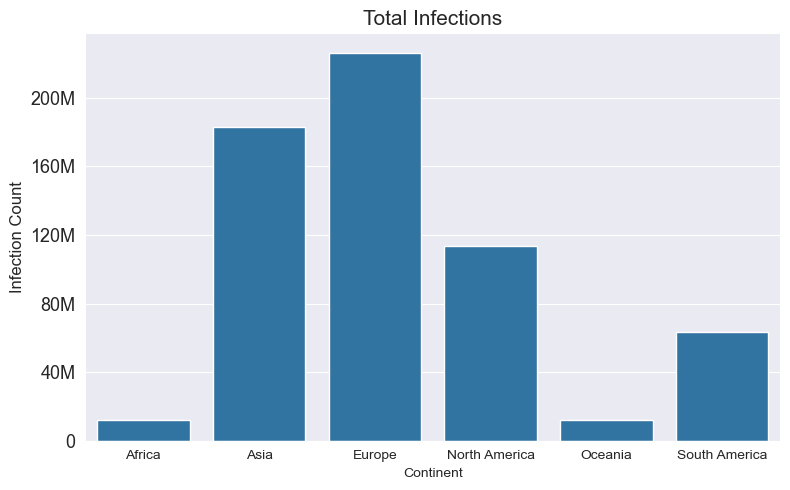

In [9]:
total_continent_cases = global_situation_data.groupby('continent')[['new_cases', 'new_deaths']].sum()\
                        .reset_index().rename(columns={'new_cases' : 'total_infections', 'new_deaths': 'total_death'})
plt.figure(figsize=(8,5))

sns.barplot(x=total_continent_cases.continent,
            y = total_continent_cases.total_infections,
            ci=None,
            estimator=sum,
            color=sns.color_palette()[0]
            )
ytick_place = np.arange(0,total_continent_cases.total_infections.max(), 4e7)
plt.yticks(ticks = ytick_place,
       labels=[str(int(i/1e6)) + 'M'  if i != 0 else 0 for i in ytick_place ],
       fontsize=13);
# plt.xticks(rotation = 45)
plt.title('Total Infections', fontsize=15)
    
    
plt.xlabel('Continent')
plt.ylabel('Infection Count', fontsize=12);
plt.tight_layout()

>We see above that Europe came first in total infection, followed by Asia, while Africa and Oceania came last.

### What is the total confirmed deaths for each continent?

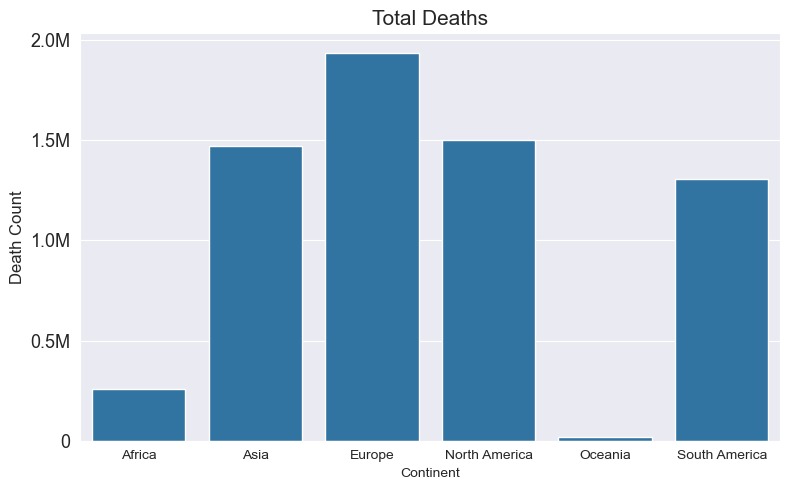

In [10]:
plt.figure(figsize=(8,5))
sns.barplot(x=total_continent_cases.continent,
            y = total_continent_cases.total_death,
            ci=None,
            estimator=sum,
            color=sns.color_palette()[0]
            )
ytick_place = np.arange(0,total_continent_cases.total_death.max()+5e5, 5e5)
plt.yticks(ticks = ytick_place,
               labels=[str(i/1e6) + 'M'  if i != 0 else 0 for i in ytick_place ],
               fontsize=13)
# plt.xticks(rotation = 45)
plt.title('Total Deaths', fontsize=15)
    
    
plt.xlabel('Continent')
plt.ylabel('Death Count', fontsize=12);
plt.tight_layout()

> We see from the figure how Europe's death cases are the highest.

> Also, we can see that Asia infection cases are more than North America yet North America death cases are more than what is in Asia. 

> Moreover, Africa's death cases are noticeably more than Oceania's even though their infection cases number is approximately the same. 

### What is the death rate by infection for each continent?

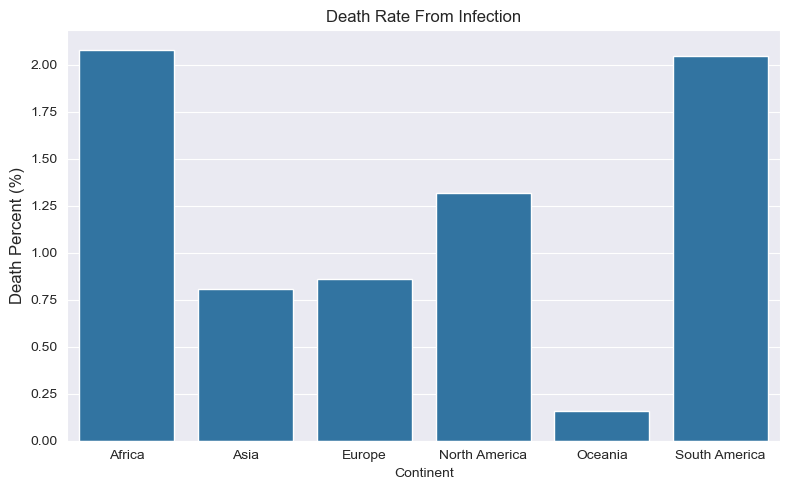

In [11]:
# creating a column for total death percent
total_continent_cases['death_percent'] = round(total_continent_cases.total_death / total_continent_cases.total_infections * 100, 2)


plt.figure(figsize=(8,5))

sns.barplot(x= total_continent_cases.continent , y= total_continent_cases.death_percent,
           color=sns.color_palette()[0])

plt.title('Death Rate From Infection')
plt.xlabel('Continent')
plt.ylabel('Death Percent (%)', fontsize=12);
plt.tight_layout()

>From the above figure, we see that:

>>Africa and South America got the highest death rate from infection cases.

>>Even though Europe and Asia had the most cases, the death rate was very low.

>>Oceania's death rate was the lowest.

### What is the infection and death cases count over time for each continent?

In [12]:
def infection_plot(df, Lookup_Value='Infection'):
    
    # Search value
    if Lookup_Value == 'Infection':
        var = 'new_cases'
        tick_step = 5e6
    elif Lookup_Value == 'Death':
        var = 'new_deaths'
        tick_step = 2e4  
    else: return "False Search Input"
    
    # Grouping data by continent and month
    cases_by_month = df.groupby(['continent','end_of_month']).sum().reset_index().sort_values('end_of_month')
    
    # Turning the end_of_month column to a string type
    cases_by_month.end_of_month = cases_by_month.end_of_month.astype('str')
    
    # Setting the figure
    plt.figure(figsize=(18,6))
    
    sns.lineplot(data =cases_by_month,
                x=cases_by_month.end_of_month,
                y = cases_by_month[f'{var}'],
                ci=None,
                estimator=sum,
                hue='continent')
    
    
    # preparing yticks values
    ytick_place = np.arange(0,int(cases_by_month[f'{var}'].max()), tick_step)
    
    ytick_label = []
    for i in ytick_place:
        # print(i)
        if i>=1e6:
            ytick_label.append(str(int(i/1e6))+'M')
        elif i>=1e4 and i<1e6:
            ytick_label.append(str(int(i/1e3))+'K')
        else:
            ytick_label.append(0)


    plt.yticks(ticks = [ytick_place[i] for i in range(0,len(ytick_place),1)],
               labels=[ytick_label[i] for i in range(0,len(ytick_label),1 )],
               fontsize=13)
    
    plt.xticks(rotation = 85);
    
    plt.title(f'{Lookup_Value} Update Over Time',
              fontsize=18)
    
    plt.ylabel(f'{Lookup_Value} Count',
               fontsize=13)
    
    plt.xlabel(f'Date [Month]',
               fontsize=13)
    # plt.tight_layout()
    return None

### 1- Infection cases update over time


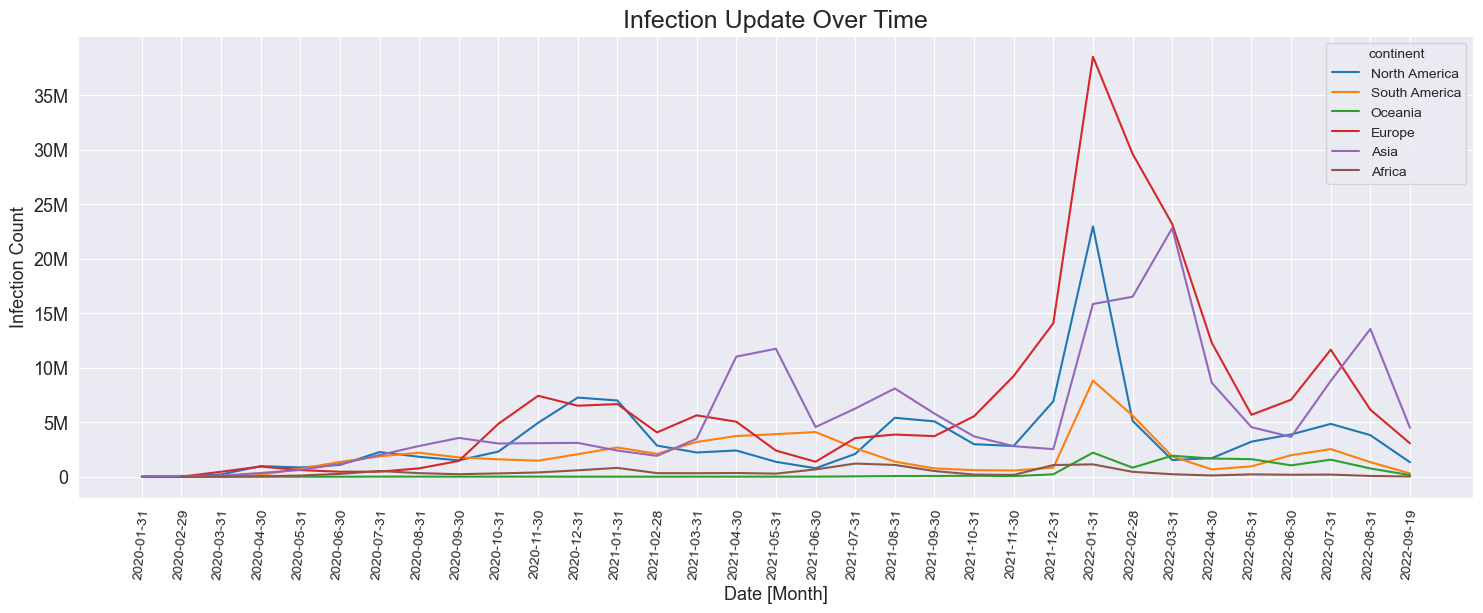

In [13]:
infection_plot(global_situation_data.copy(), 'Infection')

> From the figure above, we see the infection update over time:

>> Almost all the continents kept on increasing the infection number, Europe was the first to hit over 5 million cases in a single month, followed by North America then Asia hit a big spike with over 10 million cases in April and May 2021, then the largest increment for almost every continent started from the end of November 2021, the peak was in Europe with over 35 million cases by the end of Jan 2022 followed by North America and Asia that hit over 20 million cases, then the situation decreased sharply by the end of March 2022, cases for each continent didn't go over 5 million cases per month except for Europe that hit over 10 million cases again by July 2022 followed by Asia at August but, both of them show a sharp decrement after that.

### 2- Death cases update over time

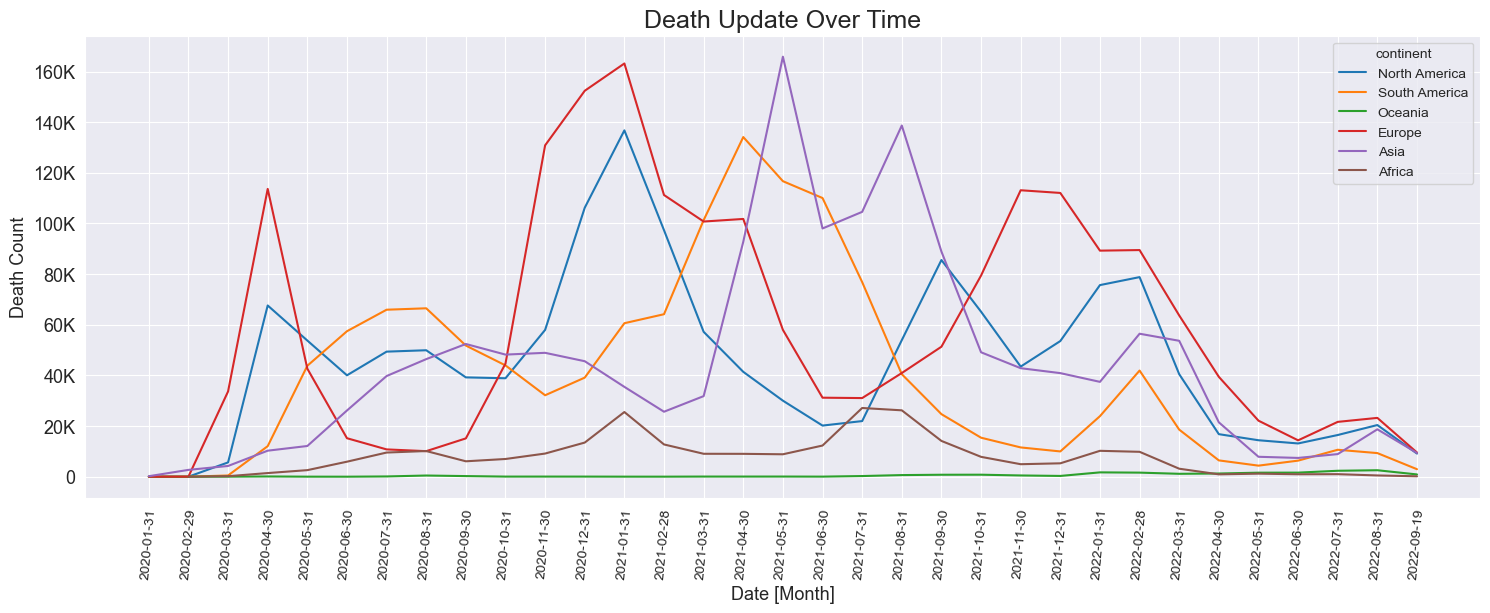

In [14]:
infection_plot(global_situation_data.copy(), 'Death')

>From the figure above, we see that: 

>>First death cases started in January 2020, then the death cases kept going up and down with a noticeably high death number in Europe followed by North America, South America, and Asia. 
 
>>Around March 2022, death cases started to rapidly decrease in every continent. 

>>Oceana's death cases seem to be very stable over time with a very small increase after December 2021.

### What is the proportion of death and infection in the population caused by COVID-19 over time?

In [15]:
# population infection rate 
global_situation_data['infection_percent'] = global_situation_data.total_cases / global_situation_data.population * 100

# population death rate
global_situation_data['death_percent'] = global_situation_data.total_deaths / global_situation_data.population * 100

#### 1- Infection Rate Of The Population Caused By COVID-19

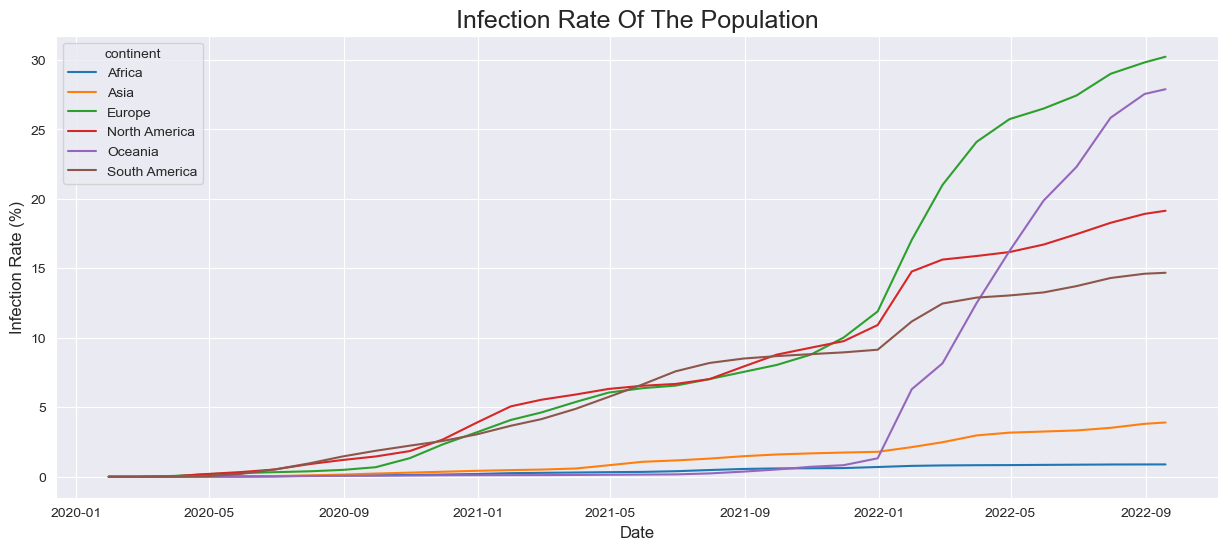

In [16]:
plt.figure(figsize=(15,6))
sns.lineplot(x=global_situation_data['end_of_month'],
             y=global_situation_data['infection_percent'],
             hue=global_situation_data['continent'])

plt.ylabel('Infection Rate (%)', fontsize=12)
plt.title('Infection Rate Of The Population', fontsize=18)
plt.xlabel('Date', fontsize=12);

>From the figure Above, we see the infection rate from the population over time:

>>The number of infected people kept on increasing over time in Europe, North America, and South America, the spread across the population was quite higher than all other continents except for Oceania, which had a dramatic increase in the infection spread suddenly by September 2022, there were approximately 27 persons out of 100 in Oceania got infected by COVID-19. Also, there was a high spread in Europe again after Jan 2022. By September 2022 there were approximately 30 persons out of 100 in Europe got infected by COVID-19

#### 2- Death Rate Of The Population Causes By COVID-19

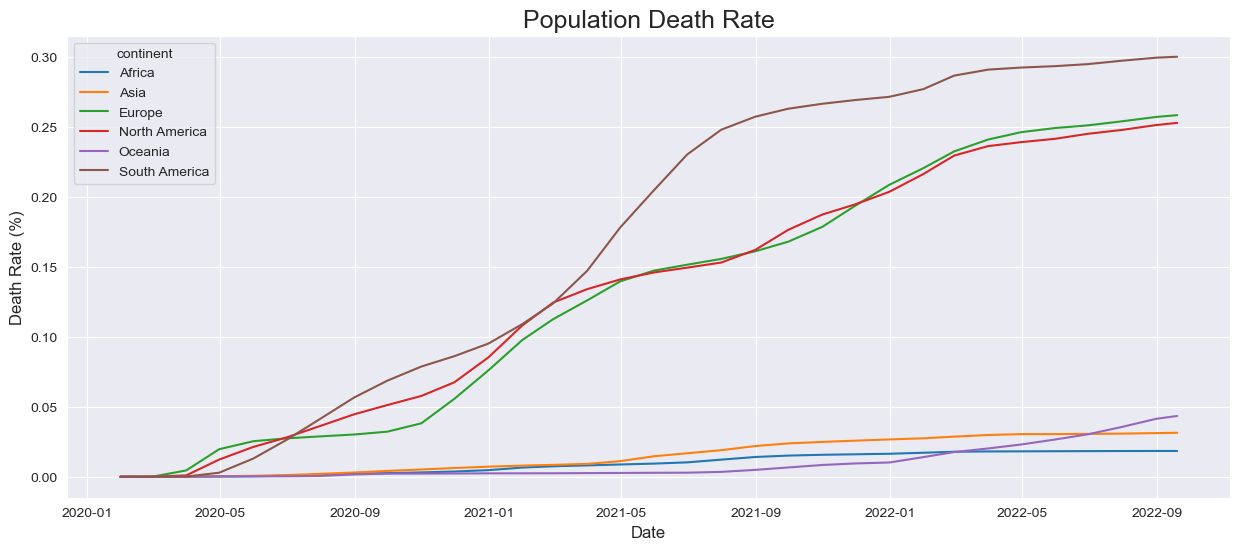

In [17]:
plt.figure(figsize=(15,6))
sns.lineplot(x=global_situation_data['end_of_month'],
             y=global_situation_data['death_percent'],
             hue=global_situation_data['continent'])

plt.ylabel('Death Rate (%)', fontsize=12)
plt.title('Population Death Rate', fontsize=18)
plt.xlabel('Date', fontsize=12);

>The above figure shows us the death rate of the population caused by COVID-19.

>>The death rate kept increasing across all the continents, with a noticeable high increase in South America,  where by September 2022, from every 1000 people, there were approximately 30 death cases.
Europe and North America were the second noticeable increase as by September 2022, for each 1000 person, there was approximately 20 death case. 

>> There was a noticeable increase death rate in Oceania after a stable record after September 2021, but thankfully it didn't go over 0.05 percent death by September 2022.